In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
from tqdm import tqdm_notebook
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt 

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

#GPU 사용 시
device = torch.device("cuda:0")

In [2]:
import random

SEED  = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
from transformers import ElectraModel
from transformers import ElectraTokenizer

tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [4]:
# 데이터를 각각 목적에 맞게 나누기
train_data = pd.read_excel('Dataset/Training.xlsx')
original_valid_data = pd.read_excel('Dataset/Validation.xlsx')

valid_data, test_data = train_test_split(original_valid_data,test_size=0.5, random_state=42, shuffle =True)

In [5]:
labels = {
    "기쁨":0,
    "기쁨 ":0,
    "불안":0,
    "불안 ":0,
    "분노":1,
    "당황":2,
    "슬픔":3,
    "상처":4
}
bool_labels = {
    "기쁨":0,
    "기쁨 ":0,
    "불안":1,
    "불안 ":1,
    "분노":1,
    "당황":1,
    "슬픔":1,
    "상처":1
}

In [6]:
class ElectraDataset(Dataset):
    def __init__(self,df):
        self.labels = [labels[label] for label in df['감정_대분류']]
        self.boollabels = [bool_labels[label] for label in df['감정_대분류']]
        self.texts = [tokenizer(str(sentence), padding = "max_length", max_length=128, truncation=True, return_tensors='pt') for sentence in df['사람문장1']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def get_batch_boollabels(self,idx):
        return np.array(self.boollabels[idx])
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        batch_bool_y = self.get_batch_boollabels(idx)
        return batch_texts, batch_y, batch_bool_y

In [7]:
class HierachicalClassifier(nn.Module):
    def __init__(self,dropout=0.5):
        super(HierachicalClassifier, self).__init__()
        self.Electra1  = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
        self.Electra2  = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)
        self.booleanlinear = nn.Linear(768,2)
        self.multilinear = nn.Linear(100,5)
        self.testlinear = nn.Linear(768,100)
        self.relu = nn.ReLU()
    
 
    def forward(self, input_id, mask):
        multi_idx = []
        boolean_idx = []
        
        pooled_output = self.Electra1(input_ids=input_id, attention_mask=mask, return_dict = False)
        x = self.dropout(pooled_output[0][:,0,:])
        x = self.booleanlinear(x)
        pro_x = self.softmax(x)
        predict_x = pro_x.argmax(dim=1).tolist()

        for i in range(len(predict_x)):
            if predict_x[i] == 1:  # bad emotion
                multi_idx.append(i)
            elif predict_x[i] == 0: # good emotion
                boolean_idx.append(i) 

        if len(multi_idx)!=0:
            multi_x = self.testlinear(pooled_output[0][multi_idx,0,:])
            multi_x = self.dropout(multi_x)
            multi_x = self.relu(multi_x)
            multi_x = self.multilinear(multi_x)
            multi_x = self.softmax(multi_x)

        bool_x = []
        multiple_x = []

        binary,multiple = 0,0 
           
        for i in range(len(predict_x)):
            if i in boolean_idx:
                bool_x.append(x[binary])
                binary = binary+1
            if i in multi_idx:
                multiple_x.append(multi_x[multiple])
                multiple = multiple+1

        if bool_x != []:
            bool_x = torch.stack(bool_x, dim=0)

        if multiple_x != []:
            multiple_x = torch.stack(multiple_x, dim=0)
        
        
        
        return bool_x, boolean_idx, multiple_x, multi_idx, pooled_output[0][boolean_idx,0,:], pooled_output[0][multi_idx,0,:]

In [8]:
def contrastive_loss(temp, embedding, label):
    cosine_sim = cosine_similarity(embedding, embedding)
    dis = cosine_sim[~np.eye(cosine_sim.shape[0], dtype=bool)].reshape(cosine_sim.shape[0], -1)
    dis = dis / temp
    cosine_sim = cosine_sim /temp
    dis = np.exp(dis)
    cosine_sim = np.exp(cosine_sim)
    
    # calculate row sum
    row_sum = []
    for i in range(len(embedding)):
        row_sum.append(sum(dis[i]))
        
    # calculate outer sum
    contrastive_loss = 0
    for i in range(len(embedding)):
        n_i = label.tolist().count(label[i]) -1
        inner_sum = 0
        
        # calculate inner sum
        for j in range(len(embedding)):
            if label[i] == label[j] and i!=j:
                inner_sum = inner_sum+ np.log(cosine_sim[i][j] / row_sum[i])
        if n_i != 0:
            contrastive_loss += (inner_sum / (-n_i))
        else:
            contrastive_loss += 0
    return contrastive_loss

In [9]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = ElectraDataset(train_data), ElectraDataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=32)
    
    use_cuda = torch.cuda.is_available()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate, weight_decay=0.05)    
    
    if use_cuda:
            criterion = criterion.cuda()

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
  
    for epoch_num in range(epochs):
        model.train()
        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label, train_bool_label in tqdm(train_dataloader):

            bool_batch_loss = 0
            multi_batch_loss = 0 
            
            bool_batch_acc = 0
            multi_batch_acc = 0
            
            optimizer.zero_grad()
            
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            model.to(device)

            bool_output, bool_idx, multi_output, multi_idx, bool_hidden_state, multi_hidden_state = model(input_id,mask)

            # bool 연산
            if bool_output != []: # 긍정이라고 판단한 것이 있다면
                bool_acc = (bool_output.argmax(dim=1).cpu() == train_bool_label[bool_idx]).sum().item()
                bool_batch_acc += bool_acc
                bool_cross_loss = criterion(bool_output.cpu(),train_bool_label[bool_idx].long())
                bool_con_loss = contrastive_loss(0.3, bool_hidden_state.cpu().detach().numpy(), train_bool_label.long())
                bool_loss = (0.8*bool_con_loss) + (1-0.8)*bool_cross_loss
                bool_batch_loss += bool_loss

            # multi 연산
            if multi_output != []:
                multi_acc = ((multi_output.argmax(dim=1)).cpu() == (train_label[multi_idx])).sum().item()
                multi_batch_acc += multi_acc
                multi_cross_loss = criterion(multi_output.cpu(), train_label[multi_idx].long())
                multi_con_loss = contrastive_loss(0.3, multi_hidden_state.cpu().detach().numpy(), (train_label).long())
                multi_loss = (0.8*multi_con_loss) + (1-0.8)*multi_cross_loss
                multi_batch_loss += multi_loss

            batch_loss = bool_batch_loss + multi_batch_loss
            batch_acc = bool_batch_acc + multi_batch_acc
            
            total_loss_train += batch_loss
            total_acc_train += batch_acc
            
            model.zero_grad()
            
            if bool_batch_loss == 0: multi_batch_loss.backward()
            elif multi_batch_loss == 0: bool_batch_loss.backward()
            else: batch_loss.backward()
            
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        model.eval()
        with torch.no_grad():
          for val_input, val_label, val_bool_label in val_dataloader:

            val_bool_batch_loss = 0
            val_multi_batch_loss = 0 
            
            val_bool_batch_acc = 0
            val_multi_batch_acc = 0
            
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            
            
            bool_output, bool_idx, multi_output, multi_idx, bool_hidden_state, multi_hidden_state = model(input_id,mask)

            # bool 연산
            if bool_output != []:
                bool_acc = (bool_output.argmax(dim=1).cpu() == val_bool_label[bool_idx]).sum().item()
                bool_batch_acc += bool_acc
                bool_cross_loss = criterion(bool_output.cpu(),val_bool_label[bool_idx].long())
                bool_con_loss = contrastive_loss(0.3, bool_hidden_state.cpu().detach().numpy(), val_bool_label.long())
                bool_loss = (0.8*bool_con_loss) + (1-0.8)*bool_cross_loss
                val_bool_batch_loss += bool_loss

            # multi 연산
            if multi_output != []:
                multi_acc = ((multi_output.argmax(dim=1)).cpu() == (val_label[multi_idx])).sum().item()
                multi_batch_acc += multi_acc
                multi_cross_loss = criterion(multi_output.cpu(), val_label[multi_idx].long())
                multi_con_loss = contrastive_loss(0.3, multi_hidden_state.cpu().detach().numpy(), (val_label).long())
                multi_loss = (0.8*multi_con_loss) + (1-0.8)*multi_cross_loss
                val_multi_batch_loss += multi_loss

            batch_loss = val_bool_batch_loss + val_multi_batch_loss
            batch_acc = val_bool_batch_acc + val_multi_batch_acc
            
            total_loss_val += batch_loss
            total_acc_val += batch_acc
            
        
        print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}') 

        total_loss_train2 = total_loss_train.cpu()/ len(train_data)
        total_acc_train2 = total_acc_train / len(train_data)
        total_loss_val2 = total_loss_val.cpu()/ len(val_data)
        total_acc_val2 = total_acc_val / len(val_data)

        train_loss_list.append(total_loss_train2.detach().numpy())
        train_acc_list.append(total_acc_train2)

        val_acc_list.append(total_acc_val2)
        val_loss_list.append(total_loss_val2.detach().numpy())  

    epochs = np.arange(1,epochs+1) 
    plt.figure(figsize=(10,5))
    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Train_Loss')
    plt.plot(epochs, train_loss_list)
    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Train_Accuracy')
    plt.plot(epochs, train_acc_list)

    plt.figure(figsize=(10,5))
    plt.subplot(2,2,3)
    plt.xlabel('Epoch')
    plt.ylabel('Valid_Loss')
    plt.plot(epochs, val_loss_list)
    plt.subplot(2,2,4)
    plt.xlabel('Epoch')
    plt.ylabel('Valid_Accuracy')
    plt.plot(epochs, val_acc_list)

    plt.show()     

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bi

Epochs: 1 | Train Loss:  2.680                 | Train Accuracy:  0.292                 | Val Loss:  2.746                 | Val Accuracy:  0.000


100%|██████████| 1614/1614 [07:57<00:00,  3.38it/s]


Epochs: 2 | Train Loss:  2.753                 | Train Accuracy:  0.305                 | Val Loss:  2.745                 | Val Accuracy:  0.000


100%|██████████| 1614/1614 [08:02<00:00,  3.35it/s]


Epochs: 3 | Train Loss:  2.761                 | Train Accuracy:  0.304                 | Val Loss:  2.745                 | Val Accuracy:  0.000


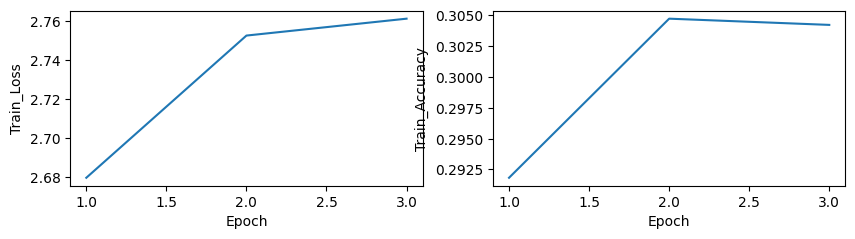

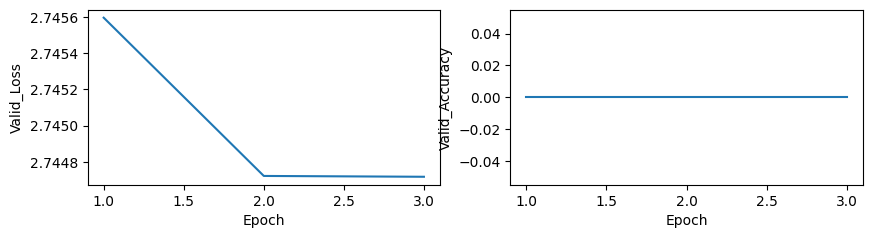

In [10]:
EPOCHS = 3
model =HierachicalClassifier()
LR = 1e-5

train(model, train_data, valid_data, LR, EPOCHS)

In [11]:
def evaluate(model, test_data):
    
    test = ElectraDataset(test_data)
    
    test_dataloader = torch.utils.data.DataLoader(test,batch_size=2)


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
 
    if use_cuda:
            criterion = criterion.cuda()
    
    total_acc_test =0

    total_output = []
    total_label = []

    total_loss_test = 0 
    total_acc_test = 0
    with torch.no_grad():
      for test_input, test_label, test_bool_label in test_dataloader:            
          test_label = test_label.to(device)
          test_label_list = test_label.tolist()
          test_bool_label_list = test_bool_label.tolist()
                    
          mask = test_input['attention_mask'].to(device)
          input_id = test_input['input_ids'].squeeze(1).to(device)

          output= model(input_id, mask)
          # bool_output, bool_idx, multi_output, multi_idx, bool_hidden_state, multi_hidden_state = model(input_id,mask)


          if len(output) == 0 : continue
          for i in range(len(output)):
            test_bool_batch_loss = 0
            test_multi_batch_loss = 0 
            
            test_bool_batch_acc = 0
            test_multi_batch_acc = 0

            if output[i].shape == torch.Size([2]): #첫번째 분류기에서 걸러진 놈
                  if test_label[i].item() >= 1: # 부정이 첫번째 분류기에서 긍정으로
                      temp = torch.LongTensor([1.]).to(device)
                      
                      bool_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()

                      output_cpu = (output[i].unsqueeze(0).argmax(dim=1)).cpu().tolist() #(+1) # 0 or 1
                      total_output += output_cpu

                      temp_cp = torch.LongTensor([(test_label[i]).long()]).to(device).tolist() # 부정의 감정이라면 원래 정답 라벨 넣어주기
                      total_label+= temp_cp

                      test_bool_batch_acc += bool_acc
                      test_bool_batch_loss += criterion(output[i].unsqueeze(0),temp)

                  else: # 긍정이 첫번째 분류기에서 긍정으로
                      temp = torch.LongTensor([0.]).to(device)
                      
                      bool_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()

                      output_cpu = output[i].unsqueeze(0).argmax(dim=1).cpu().tolist()
                      total_output += output_cpu

                      temp_cp = temp.cpu().tolist()
                      total_label+= temp_cp

                      test_bool_batch_acc += bool_acc
                      test_bool_batch_loss += criterion(output[i].unsqueeze(0),temp)

            elif output[i].shape == torch.Size([5]):
                  if test_label[i] == 0: # 긍정이 부정으로 잘못 분류된 경우
                    temp = torch.LongTensor([(test_label[i]).long()]).to(device)        
                    temp_cp = temp.cpu().tolist()
                    output_cpu = (output[i].unsqueeze(0).argmax(dim=1)).cpu().tolist()
                    total_output += output_cpu

                  else: # 부정이 부정으로 분류된 경우
                    temp = torch.LongTensor([(test_label[i]-1).long()]).to(device) # -1
                    temp_cp = (temp+1).cpu().tolist() # +1
                    output_cpu = (output[i].unsqueeze(0).argmax(dim=1)+1).cpu().tolist()
                    total_output += output_cpu
                  total_label+= temp_cp

                  multi_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()
                  test_multi_batch_acc += multi_acc
                  test_multi_batch_loss += criterion(output[i].unsqueeze(0), temp)
                    
          batch_loss = test_bool_batch_loss + test_multi_batch_loss
          batch_acc = test_bool_batch_acc + test_multi_batch_acc
            
          total_loss_test += batch_loss
          total_acc_test += batch_acc

    print(classification_report(total_label,total_output))
'''
def evaluate(model, test_data):
    
    test = ElectraDataset(test_data)
    
    test_dataloader = torch.utils.data.DataLoader(test,batch_size=2)


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
 
    if use_cuda:
            criterion = criterion.cuda()
    
    total_acc_test =0

    total_output = []
    total_label = []

    total_loss_test = 0 
    total_acc_test = 0
    with torch.no_grad():
      for test_input, test_label in test_dataloader:            
          test_label = test_label.to(device)
          test_label_list = test_label.tolist()
        
                  
          mask = test_input['attention_mask'].to(device)
          input_id = test_input['input_ids'].squeeze(1).to(device)

          output= model(input_id, mask)


          if len(output) == 0 : continue
          for i in range(len(output)):
            test_bool_batch_loss = 0
            test_multi_batch_loss = 0 
            
            test_bool_batch_acc = 0
            test_multi_batch_acc = 0
            if output[i].shape == torch.Size([2]): #첫번째 분류기에서 걸러진 놈
                  if test_label[i].item() >= 1: 
                      temp = torch.LongTensor([1.]).to(device)
                      
                      bool_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()

                      output_cpu = (output[i].unsqueeze(0).argmax(dim=1)+1).cpu().tolist() #(+1)
                      total_output += output_cpu

                      temp_cp = torch.LongTensor([(test_label[i]).long()]).to(device).tolist() # 부정의 감정이라면 원래 정답 라벨 넣어주기
                      total_label+= temp_cp

                      test_bool_batch_acc += bool_acc
                      test_bool_batch_loss += criterion(output[i].unsqueeze(0),temp)
                  else:
                      temp = torch.LongTensor([0.]).to(device)
                      
                      bool_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()

                      output_cpu = output[i].unsqueeze(0).argmax(dim=1).cpu().tolist()
                      total_output += output_cpu

                      temp_cp = temp.cpu().tolist()
                      total_label+= temp_cp

                      test_bool_batch_acc += bool_acc
                      test_bool_batch_loss += criterion(output[i].unsqueeze(0),temp)

            elif output[i].shape == torch.Size([5]):
                  if test_label[i] == 0: # 긍정이 부정으로 잘못 분류된 경우
                    temp = torch.LongTensor([(test_label[i]).long()]).to(device)        
                    temp_cp = temp.cpu().tolist()
                    output_cpu = (output[i].unsqueeze(0).argmax(dim=1)).cpu().tolist()
                    total_output += output_cpu

                  else: # 부정이 부정으로 분류된 경우
                    temp = torch.LongTensor([(test_label[i]-1).long()]).to(device) # -1
                    temp_cp = (temp+1).cpu().tolist() # +1
                    output_cpu = (output[i].unsqueeze(0).argmax(dim=1)+1).cpu().tolist()
                    total_output += output_cpu

                  total_label+= temp_cp
                  multi_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()
                  test_multi_batch_acc += multi_acc
                  test_multi_batch_loss += criterion(output[i].unsqueeze(0), temp)
                    
          batch_loss = test_bool_batch_loss + test_multi_batch_loss
          batch_acc = test_bool_batch_acc + test_multi_batch_acc
            
          total_loss_test += batch_loss
          total_acc_test += batch_acc

    print(classification_report(total_label,total_output))
  '''

'\ndef evaluate(model, test_data):\n    \n    test = ElectraDataset(test_data)\n    \n    test_dataloader = torch.utils.data.DataLoader(test,batch_size=2)\n\n\n    use_cuda = torch.cuda.is_available()\n    device = torch.device("cuda" if use_cuda else "cpu")\n\n    criterion = nn.CrossEntropyLoss()\n \n    if use_cuda:\n            criterion = criterion.cuda()\n    \n    total_acc_test =0\n\n    total_output = []\n    total_label = []\n\n    total_loss_test = 0 \n    total_acc_test = 0\n    with torch.no_grad():\n      for test_input, test_label in test_dataloader:            \n          test_label = test_label.to(device)\n          test_label_list = test_label.tolist()\n        \n                  \n          mask = test_input[\'attention_mask\'].to(device)\n          input_id = test_input[\'input_ids\'].squeeze(1).to(device)\n\n          output= model(input_id, mask)\n\n\n          if len(output) == 0 : continue\n          for i in range(len(output)):\n            test_bool_batch_los

In [12]:
import time

global total_acc_test

start_time = time.time()
evaluate(model,test_data)
print("---{}s seconds---".format(time.time()-start_time))

ValueError: too many values to unpack (expected 2)

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/HierarchicalKoELEECTRA_v7')